# Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from io import BytesIO
import geopandas as gpd

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

classifications = ["lcWestClassifications", "lcSouthClassifications", "lcEastClassifications", "lcNorthClassifications"]
url_entries = ["lcDownwardPhotoUrl", "lcEastPhotoUrl", "lcUpwardPhotoUrl", "lcNorthPhotoUrl", "lcSouthPhotoUrl", "lcWestPhotoUrl"]

# Downloading Data

## Parameters

- "get_app_only": Set to True to only download data collected from the GLOBE Observer App
- "get_site_coordinates": Set to True to set the latitude/longitude of the data from the MGRS System to the coordinates collected by the GPS
- "start_date" and "end_date": Time frame for the data

In [2]:
# get app data
get_app_only = True

# measured at or site coordinates
get_site_coordinates = False

# dates
start_date = "2020-06-01"
end_date = "2020-07-01"

In [3]:
def switch_coordinates(df):
    """Switch latitude and longitude of a Landcover DataFrame from their current MGRS values to the GPS's measurement  
    
    Arguments:
        df: pd.DataFrame, A Pandas DataFrame Containing GLOBE Observer Landcover Data from the GLOBE API
    
    Returns:
        pd.DataFrame, a Landcover DataFrame with updated latitude and longitude columns 
    """
    
    coordinates_df = df[df["lcMeasurementLatitude"].notnull()]
    coordinates_df = coordinates_df[df["lcMeasurementLongitude"].notnull()]

    coordinates_df["latitude"] = coordinates_df["lcMeasurementLatitude"].tolist()
    coordinates_df["longitude"] = coordinates_df["lcMeasurementLongitude"].tolist()
    return coordinates_df

def app_only(df):
    """Filters a Landcover DataFrame to only contain data collected on the GLOBE Observer App
    
    Arguments:
        df: pd.DataFrame, A Pandas DataFrame Containing GLOBE Observer Landcover Data from the GLOBE API
    
    Returns:
        pd.DataFrame, A Landcover DataFrame only containing data collected by the GLOBE Observer App 
    """
    
    return df[df["lcDataSource"] == "GLOBE Observer App"]
    
    
# Build download URL
url = f"https://api.globe.gov/search/v1/measurement/protocol/measureddate/?protocols=land_covers&startdate={start_date}&enddate={end_date}&geojson=FALSE&sample=FALSE"

# Get and unpack GLOBE API Data
response = requests.get(url)
results = response.json()["results"]
df = pd.DataFrame(results)

# Expand the 'data' column by listing the contents and passing as a new dataframe
df = pd.concat([df, pd.DataFrame(list(df['data']))], axis=1)

# Drop the previously nested data column
df = df.drop('data', 1)

# Replace "landcovers" in column name with "lc" to reduce verbosity
df.columns = [col_name.replace("landcovers", "lc") for col_name in df.columns]

# Additional (optional) data cleaning scripts
if get_app_only:
    df = app_only(df)
if get_site_coordinates:
    df = switch_coordinates(df)

df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-10-06T21:36:06,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-10-06T21:36:06,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,None,"(source: app, (compassData.horizon: -81.154907...",https://data.globe.gov/system/photos/2020/06/0...,None,None,,None,,"(source: app, (compassData.horizon: 36.8326249...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/0...,None,None,None,,2020-06-02T12:44:00,None,https://data.globe.gov/system/photos/2020/06/0...,False,https://data.globe.gov/system/photos/2020/06/0...,False,True,398545.0,"(source: app, (compassData.horizon: 19.7445433...",,False,None,"(source: app, (compassData.horizon: 24.5574870...",31734,None,False,None,(none),41.5744,192.1,-83.6251
9,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 25.3517639...",https://data.globe.gov/system/photos/2020/06/0...,M91,https://data.globe.gov/system/photos/2020/06/

# Convert To Local Times

In [4]:
def convert_times(date, longitude):
    """Converts the measured date from the UTC timezone to the entry's local date.
    Adapted from Matt Bandel's Mosquito Habitat Mapper Notebook: https://github.com/IGES-Geospatial/globe-mosquitoes-notebook
    
    Arguments:
        date: str, The recorded datetime for the measurement
        longitude: float, The measured longitude for the observation
    
    Returns:
        (int, int, int, int) tuple, contains: year, month, day, day of the year (1-366)
    """
    
    # convert the date string to date object and normalize based on partitioning
    date_obj = datetime.strptime(re.sub(r"\..*", "", date), "%Y-%m-%dT%H:%M:%S")
    
    # convert the date string to date object and correct for longitude
    zone = int(round(longitude * 24 / 360, 0))
    converted = date_obj + timedelta(hours=zone)
    tt = converted.timetuple()
    
    return tt.tm_year, tt.tm_mon, tt.tm_mday, tt.tm_yday
vectorized_convert = np.vectorize(convert_times)

df["year"], df["month"], df["day"], df["day of year"] = vectorized_convert(df['lcMeasuredAt'].to_numpy(), df['longitude'].to_numpy())
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-10-06T21:36:06,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350,2020,6,27,179
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-10-06T21:36:06,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585,2020,6,27,179
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,None,"(source: app, (compassData.horizon: -81.154907...",https://data.globe.gov/system/photos/2020/06/0...,None,None,,None,,"(source: app, (compassData.horizon: 36.8326249...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/0...,None,None,None,,2020-06-02T12:44:00,None,https://data.globe.gov/system/photos/2020/06/0...,False,https://data.globe.gov/system/photos/2020/06/0...,False,True,398545.0,"(source: app, (compassData.horizon: 19.7445433...",,False,None,"(source: app, (compassData.horizon: 24.5574870...",31734,None,False,None,(none),41.5744,192.1,-83.6251,2020,6,2,154
9,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 25.3517639...",https://data.globe.gov/system/p

# Image Resolution, Size, and Score 

In [5]:
def get_resolution(df):
    """Gets the resolutions for images in a Landcover DataFrame
    
    Arguments:
        df: pd.DataFrame, a Pandas DataFrame Containing GLOBE Observer Landcover Data from the GLOBE API
    
    Returns:
        pd.DataFrame, an updated Landcover DataFrame with columns for image resolutions in all image directions
    """
    
    # helper function
    def get_entry_resolution(row):
        """Adds columns to a Landcover DataFrame row containing image resolution, file size, and content score.
        Content score is file size divided by pixels.
        
        Arguments:
            row: pd.Series, A Pandas DataFrame Row Containing GLOBE Observer Landcover Data from the GLOBE API
        
        Returns:
            pd.Series, An updated row with columns for image resolutions in all image directions
        """
        
        def calc_data(row, entry):
            """Adds columns to Landcover DataFrame Row containing image resolution, file size, and content score
            
            Arguments:
                row: pd.Series, A Pandas DataFrame Row Containing GLOBE Observer Landcover Data from the GLOBE API
                entry: str, the column key for the url entry of the row
            
            Returns:
                pd.Series, An updated row with columns for the specified direction
            """
            
            if row[entry] and "https" in row[entry]:
                    response = requests.get(row[entry], stream=True)
                    resolution = Image.open(BytesIO(response.content)).size 
                    size = len(response.content)
                
                    row[entry.replace("Url", "Rez")] = resolution
                    row[entry.replace("Url", "Size")] = size / 1000000 # convert to megabytes
                    row[entry.replace("Url", "ContentScore")] = size / (resolution[0] * resolution[1]) # bytes / pixel
            return row
            
        
        for entry in url_entries:
            try:
                row = calc_data(row, entry)
            except Exception as e:
                print(f"{row[entry]} failed, retrying...")
                try:
                    row = calc_data(row, entry)
                    print("retry succeded")
                except Exception as e:
                    print(f"{row[entry]} failed: {repr(e)}")
        return row
    
    
    # Add in columns into DataFrame with default null value
    for entry in url_entries:
        df[entry.replace("Url", "Rez")] = np.nan
        df[entry.replace("Url", "Size")] = np.nan
        df[entry.replace("Url", "ContentScore")] = np.nan
    
    
    # Apply helper function to all DataFrame Rows
    return df.apply(get_entry_resolution, axis=1)


%time df = get_resolution(df)

https://data.globe.gov/system/photos/2020/06/24/1713157/original.jpg failed, retrying...
retry succeded
Wall time: 7h 10min 54s


In [6]:
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,lcDownwardPhotoRez,lcDownwardPhotoSize,lcDownwardPhotoContentScore,lcEastPhotoRez,lcEastPhotoSize,lcEastPhotoContentScore,lcUpwardPhotoRez,lcUpwardPhotoSize,lcUpwardPhotoContentScore,lcNorthPhotoRez,lcNorthPhotoSize,lcNorthPhotoContentScore,lcSouthPhotoRez,lcSouthPhotoSize,lcSouthPhotoContentScore,lcWestPhotoRez,lcWestPhotoSize,lcWestPhotoContentScore
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-10-06T21:36:06,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350,2020,6,27,179,"(1080, 810)",0.205999,0.235481,"(1080, 810)",0.241617,0.276197,"(1080, 810)",0.401341,0.458780,"(1080, 810)",0.423377,0.483970,"(1080, 810)",0.441537,0.504729,"(1080, 810)",0.407616,0.465953
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-10-06T21:36:06,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585,2020,6,27,179,"(1080, 810)",0.442642,0.505992,"(1080, 810)",0.320361,0.366211,"(1080, 810)",0.173908,0.198797,"(1080, 810)",0.487821,0.557637,"(1080, 810)",0.435594,0.497936,"(1080, 810)",0.267216,0.305460
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,None,"(source: app, (compassData.horizon: -81.154907...",https://data.globe.gov/system/photos/2020/06/0...,None,None,,None,,"(source: app, (compassData.horizon: 36.8326249...",GLOBE Observer App,True,None,,

# Download Photos

The option variable decides between three options for downloading photos:

1. "original": Downloads the original photo
2. "1080p": Resizes the original photo into 1920x1080 resolution
3. "overlay": Overlays an image collar at the bottom of every image containing photo ID, direction, siteID, date and MUC classification

In [7]:
option = "1080p"

In [8]:
def download_photo(row, option):
    """Downloads photos in a Landcover DataFrame with 3 download options: original, 1080p, and overlay.
    
    Arguments:
        row: pd.Series, A Pandas DataFrame Row Containing GLOBE Observer Landcover Data from the GLOBE API
        option: str, 1 of 3 possible strings: original (original photo), 1080p (scale photo to 1080p), and overlay (add image data as image collar).
    
    Returns:
        None
    """
    
    # 3 different helper functions
    
    def resize(img, info):
        """Resizes image to 1080p and saves it in the Image Directory with relevant data in its filename
        
        Arguments: 
            img: Image, an Image object
            info: str, a string containing relevant data for the image
            
        Returns:
            None
        """
        
        img.resize((1920, 1080)).save(f"Images/{info}.jpg")
    
    def overlay(img, info):
        """Downloads image and saves it in the Image Directory with relevant data in an image collar at the bottom of the image.
        
        Arguments: 
            img: Image, an Image object
            info: str, a string containing relevant data for the image
            
        Returns:
            None
        """
        
        draw = ImageDraw.Draw(img)
        draw.line([(0,img.size[1]), (img.size[0], img.size[1])], width = 200, fill="#FFFFFF")
        fnt = ImageFont.truetype("arial.ttf", 40)
        draw.text((0,img.size[1] - 100), info, font = fnt, fill = "#000000", align = "right")
        img.save(f"Images/{re.search(r'.*(?=-[a-zA-Z]*-)', info).group(0)}.jpg")

    def original(img, info):
        """Saves image in the Image Directory with relevant data in its filename
        
        Arguments: 
            img: Image, an Image object
            info: str, a string containing relevant data for the image
            
        Returns:
            None
        """
        
        img.save(f"Images/{info}.jpg")
    
    def get_img(url):
        """Downloads an image from a url
        
        Arguments:
            url: str, an image URL for a GLOBE Landcover Image
            
        Returns:
            None
        """
        
        try:
            return Image.open(requests.get(url, stream=True).raw)
        except Exception as e:
            print(f"{url} failed, retrying...")
            try:
                img = Image.open(requests.get(url, stream=True).raw)
                print("retry successful")
                return img
            except Exception as e:
                print(f"{url} failed: {repr(e)}")
            return None
        
    def download_photo(url, direction, siteid, date, muc, option):
        """Downloads a photo with relevant data saved either with the filename or overlayed on the image
        
        Arguments:
            url: str, the URL for the image
            direction: str, the direction (Upwards, Downwards, North, East, South, and West) the image was taken in
            siteid: str, the siteID for the image
            date: str, the date the image was taken
            muc: str, the MUC classification code
            option: str, one of three photo downloading options: "original", "1080p", or "overlay"
        
        Returns:
            None
        """
        
        if url and "https" in url:
            photo_id = re.search(r'(?<=\d\d\d\d\/\d\d\/\d\d\/).*(?=\/)', url).group(0)
            img_info = f"{photo_id}-{direction}-{siteid}-{date}-{muc}"
        
            img = get_img(url)
        
        
            options = {"original" : original, "1080p": resize, "overlay": overlay}
            options[option](img, img_info)
    
    # Makes Image directory if it doesn't exist
    if not os.path.exists("Images"):
        os.makedirs("Images")
    
    # Downloads Images
    for entry in url_entries:
        download_photo(row[entry], entry.replace("lc", "").replace("Url", ""), row["siteId"], row["measuredDate"], row['lcMucCode'], option)
%time out = df.apply(download_photo, option=option, axis=1)     

https://data.globe.gov/system/photos/2020/06/14/1685971/original.jpg failed, retrying...
retry successful
https://data.globe.gov/system/photos/2020/07/01/1747439/original.jpg failed, retrying...
retry successful
Wall time: 6h 40min 25s


# Plot Count over time

Plots a bar graph of datapoints collected for each day specified in date range

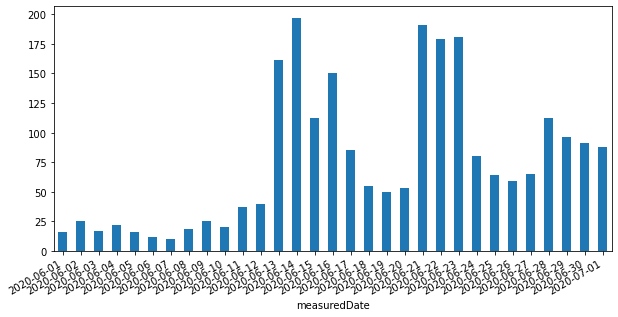

In [9]:
time_series = df.groupby("measuredDate").size()

fig = plt.figure(figsize = (10, 5))
time_series.plot.bar()
fig.autofmt_xdate()

# Classifications analysis


In [10]:
def get_classifications(*args):
    """Figures out the primary and secondary landcover type and percentage for each valid set of classifications.
    
    Arguments:
        *args: list of strings, classifications for each direction.
    
    Returns:
        (str, float, str, float) tuple, contains: primary lc type, primary lc percentage, secondary lc type, secondary lc percentage. 
    """
    
    # generate classification list
    valid_entries = [entry for entry in args if entry != None and "%" in entry]
    classification_list = [obj.split("%") for sublist in valid_entries for obj in sublist.split(";")]
    
    # set primary, secondary default values to None
    primary, secondary = (None, None), (None, None)
    
    # checks if there are valid classifications 
    if len(classification_list) > 0:
        # adds in all unique classifications and updates percentages
        classification_dict = {}
        for classification in classification_list:
            classification[1] = classification[1].lstrip()
            if classification_dict.get(classification[1], 0) == 0:
                classification_dict[classification[1]] = int(classification[0])
            else:
                classification_dict[classification[1]] += int(classification[0])

        # average the summed percentages for each entry over all directions passed
        for key, value in classification_dict.items():
            classification_dict[key] = value / len(args)
        
        # sort the dict to get primary and secondary types on front
        classification_dict = {k: v for k, v in sorted(classification_dict.items(), key=lambda item: item[1], reverse=True)}
        
        # try and pull primary and secondary values
        iterator = iter(classification_dict.items())
        primary = next(iterator)
        try:
            secondary = next(iterator)
        except StopIteration:
            pass
    return primary[0], primary[1], secondary[0], secondary[1]

classification_getter = np.vectorize(get_classifications)

df["primary_type"], df["primary_percentage"], df["secondary_type"], df["secondary_percentage"] = classification_getter(
    df["lcEastClassifications"].to_numpy(),
    df["lcNorthClassifications"].to_numpy(),
    df["lcSouthClassifications"].to_numpy(),
    df["lcWestClassifications"].to_numpy(),
)

In [11]:
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,lcDownwardPhotoRez,lcDownwardPhotoSize,lcDownwardPhotoContentScore,lcEastPhotoRez,lcEastPhotoSize,lcEastPhotoContentScore,lcUpwardPhotoRez,lcUpwardPhotoSize,lcUpwardPhotoContentScore,lcNorthPhotoRez,lcNorthPhotoSize,lcNorthPhotoContentScore,lcSouthPhotoRez,lcSouthPhotoSize,lcSouthPhotoContentScore,lcWestPhotoRez,lcWestPhotoSize,lcWestPhotoContentScore,primary_type,primary_percentage,secondary_type,secondary_percentage
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-10-06T21:36:06,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350,2020,6,27,179,"(1080, 810)",0.205999,0.235481,"(1080, 810)",0.241617,0.276197,"(1080, 810)",0.401341,0.458780,"(1080, 810)",0.423377,0.483970,"(1080, 810)",0.441537,0.504729,"(1080, 810)",0.407616,0.465953,None,None,None,None
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-10-06T21:36:06,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585,2020,6,27,179,"(1080, 810)",0.442642,0.505992,"(1080, 810)",0.320361,0.366211,"(1080, 810)",0.173908,0.198797,"(1080, 810)",0.487821,0.557637,"(1080, 810)",0.435594,0.497936,"(1080, 810)",0.267216,0.305460,None,None,None,None
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,None,"(source: app, (compassData.horizon: -81.154907...",https://data.globe.gov/system/photos/2020

# Identify Repeats

Returns a data frame of suspected repeat entrys and removes them from the DataFrame (keeping the first entry). It does this by finding entries made in the same location within a certain time frame. This time frame can be specified as explained below.

## Usage:

"same_day": If set to True, the program only flags entrys made within the same day, if set to False it will only take location into account (any coincident observations within the dataset's date range will be flagged)

In [12]:
same_day = True

In [13]:
if same_day:
    suspect_repeats = df.groupby(by = ["measuredDate", "lcMeasurementLatitude", "lcMeasurementLongitude"]).filter(lambda x: len(x) > 1)
    df = df.drop_duplicates(subset = ["measuredDate", "lcMeasurementLatitude", "lcMeasurementLongitude"], keep ="first")    
else:
    suspect_repeats = df.groupby(by = ["lcMeasurementLatitude", "lcMeasurementLongitude"]).filter(lambda x: len(x) > 1)
    df = df.drop_duplicates(subset = ["lcMeasurementLatitude", "lcMeasurementLongitude"], keep ="first")  

In [14]:
suspect_repeats

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,lcDownwardPhotoRez,lcDownwardPhotoSize,lcDownwardPhotoContentScore,lcEastPhotoRez,lcEastPhotoSize,lcEastPhotoContentScore,lcUpwardPhotoRez,lcUpwardPhotoSize,lcUpwardPhotoContentScore,lcNorthPhotoRez,lcNorthPhotoSize,lcNorthPhotoContentScore,lcSouthPhotoRez,lcSouthPhotoSize,lcSouthPhotoContentScore,lcWestPhotoRez,lcWestPhotoSize,lcWestPhotoContentScore,primary_type,primary_percentage,secondary_type,secondary_percentage
263,land_covers,2020-06-17,2020-06-17T14:30:03,2020-06-17T15:55:46,2020-10-06T21:36:06,17043304,United States of America Citizen Science,201860,14RPU126672,None,None,30.431642,-97.827460,284.2,163688902,https://data.globe.gov/system/photos/2020/06/1...,"(source: app, (compassData.horizon: -34.603711...",https://data.globe.gov/system/photos/2020/06/1...,None,https://data.globe.gov/system/photos/2020/06/1...,,None,,"(source: app, (compassData.horizon: -15.866070...",GLOBE Observer App,False,None,,https://data.globe.gov/system/photos/2020/06/1...,,"(source: app, (compassData.horizon: -89.605428...",None,,2020-06-17T14:24:00,,https://data.globe.gov/system/photos/2020/06/1...,False,https://data.globe.gov/system/photos/2020/06/1...,False,True,67227647.0,"(source: app, (compassData.horizon: -34.740328...",,False,"(source: app, (compassData.horizon: 88.5682613...","(source: app, (compassData.horizon: -14.912261...",32721,None,False,None,(none),30.4323,285.0,-97.8268,2020,6,17,169,"(1080, 810)",0.696285,0.795936,"(1080, 810)",0.505249,0.577559,"(1080, 810)",0.437189,0.499759,"(1080, 810)",0.581445,0.664660,"(1080, 810)",0.566780,0.647897,"(1080, 810)",0.542724,0.620398,None,None,None,None
265,land_covers,2020-06-17,2020-06-17T14:30:03,2020-06-17T15:55:46,2020-10-06T21:36:06,17043304,United States of America Citizen Science,201860,14RPU126672,None,None,30.431642,-97.827460,284.2,163688902,https://data.globe.gov/system/photos/2020/06/1...,"(source: app, (compassData.horizon: -40.655380...",https://data.globe.gov/system/photos/2020/06/1...,None,https://data.globe.gov/system/photos/2020/06/1...,,None,,"(source: app, (compassData.horizon: -18.551572...",GLOBE Observer App,False,None,,https://data.globe.gov/system/photos/2020/06/1...,,"(source: app, (compassData.horizon: -88.170425...",None,,2020-06-17T14:26:00,,https://data.globe.gov/system/photos/2020/06/1...,False,https://data.globe.gov/system/photos/2020/06/1...,False,True,67227647.0,"(source: app, (compassData.horizon: -51.515313...",,False,"(source: app, (compassData.horizon: -68.515074...","(source: app, (compassData.horizon: -28.042100...",32722,None,False,None,(none),30.4323,285.0,-97.8268,2020,6,17,169,"(1080, 810)",0.277619,0.317351,"(1080, 810)",0.629539,0.719638,"(1080, 810)",0.129830,0.148411,"(1080, 810)",0.553774,0.633029,"(1080, 810)",0.624348,0.713704,"(1080, 810)",0.549958,0.628667,None,None,None,None
348,land_covers,2020-06-10,2020-06-10T23:40:02,2020-06-12T18:00:10,2020-10-06T21:36:06,17615655,Thailand Citizen Science,202219,47QPU433745,None,None,16.949869,100.345797,52.0,163662707,https://data.globe.gov/system/photos/2020/06/1...,(source: camera),https://data.globe.gov/system/photos/2020/06/1...,None,https://data.globe.gov/system/photos/2020/06/1...,

In [15]:
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,lcDownwardPhotoRez,lcDownwardPhotoSize,lcDownwardPhotoContentScore,lcEastPhotoRez,lcEastPhotoSize,lcEastPhotoContentScore,lcUpwardPhotoRez,lcUpwardPhotoSize,lcUpwardPhotoContentScore,lcNorthPhotoRez,lcNorthPhotoSize,lcNorthPhotoContentScore,lcSouthPhotoRez,lcSouthPhotoSize,lcSouthPhotoContentScore,lcWestPhotoRez,lcWestPhotoSize,lcWestPhotoContentScore,primary_type,primary_percentage,secondary_type,secondary_percentage
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-10-06T21:36:06,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350,2020,6,27,179,"(1080, 810)",0.205999,0.235481,"(1080, 810)",0.241617,0.276197,"(1080, 810)",0.401341,0.458780,"(1080, 810)",0.423377,0.483970,"(1080, 810)",0.441537,0.504729,"(1080, 810)",0.407616,0.465953,None,None,None,None
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-10-06T21:36:06,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585,2020,6,27,179,"(1080, 810)",0.442642,0.505992,"(1080, 810)",0.320361,0.366211,"(1080, 810)",0.173908,0.198797,"(1080, 810)",0.487821,0.557637,"(1080, 810)",0.435594,0.497936,"(1080, 810)",0.267216,0.305460,None,None,None,None
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,None,"(source: app, (compassData.horizon: -81.154907...",https://data.globe.gov/system/photos/2020

# Get Decimal Precision

Counts trailing decimals for latitude longitude measurements and appends the data to the dataframe under the "x_decimal" (longitude) and "y_decimal" (latitude) columns.

In [16]:
def get_precision(latitude, longitude):
    """Gets the decimal precision of latitude and longitude measurements
    
    Arguments:
        latitude: float, a latitude value
        longitude: float, a longitude value
        
    Returns:
        (int, int) tuple, contains: longitude precision and latitude precision
    """
    
    y_decimal = 0
    x_decimal = 0
    try:
        y_decimal = len(str(latitude).split(".")[1])
    except IndexError:
        pass
    try:
        x_decimal = len(str(longitude).split(".")[1])
    except IndexError:
        pass
    
    return x_decimal, y_decimal

vectorized_precision = np.vectorize(get_precision)

df["x_decimal"], df["y_decimal"] = vectorized_precision(df["lcMeasurementLatitude"].to_numpy(), df["lcMeasurementLongitude"].to_numpy())

In [17]:
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,lcDownwardPhotoRez,lcDownwardPhotoSize,lcDownwardPhotoContentScore,lcEastPhotoRez,lcEastPhotoSize,lcEastPhotoContentScore,lcUpwardPhotoRez,lcUpwardPhotoSize,lcUpwardPhotoContentScore,lcNorthPhotoRez,lcNorthPhotoSize,lcNorthPhotoContentScore,lcSouthPhotoRez,lcSouthPhotoSize,lcSouthPhotoContentScore,lcWestPhotoRez,lcWestPhotoSize,lcWestPhotoContentScore,primary_type,primary_percentage,secondary_type,secondary_percentage,x_decimal,y_decimal
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-10-06T21:36:06,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350,2020,6,27,179,"(1080, 810)",0.205999,0.235481,"(1080, 810)",0.241617,0.276197,"(1080, 810)",0.401341,0.458780,"(1080, 810)",0.423377,0.483970,"(1080, 810)",0.441537,0.504729,"(1080, 810)",0.407616,0.465953,None,None,None,None,3,4
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-10-06T21:36:06,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585,2020,6,27,179,"(1080, 810)",0.442642,0.505992,"(1080, 810)",0.320361,0.366211,"(1080, 810)",0.173908,0.198797,"(1080, 810)",0.487821,0.557637,"(1080, 810)",0.435594,0.497936,"(1080, 810)",0.267216,0.305460,None,None,None,None,4,2
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,None,"(source: app, (compassData.horizon: -81.154907...",https://data.

# Count Valid 

Counts the number of valid photo entries ("photo_count") and classifications ("classification_count") for each row in the dataset. 

In [18]:
def count_valid(identifier, *args):
    """Count the number of valid entries for a set of values
    
    Arguments:
        identifier: str, a string that all valid entries should contain
        *args: list of strings, collected data entries that may or may not be valid
    
    Returns:
        int, the number of valid data entries
    """
    
    count = 0 
    for url in args:
        if url and identifier in url:
            count += 1
    return count


vectorize_count = np.vectorize(count_valid)
df["photo_count"] = vectorize_count(
    "http",
    df["lcDownwardPhotoUrl"].to_numpy(),
    df["lcUpwardPhotoUrl"].to_numpy(),
    df["lcEastPhotoUrl"].to_numpy(),
    df["lcNorthPhotoUrl"].to_numpy(),
    df["lcSouthPhotoUrl"].to_numpy(),
    df["lcWestPhotoUrl"].to_numpy(),
)

df["classification_count"] = vectorize_count(
    "%",
    df["lcEastClassifications"].to_numpy(),
    df["lcNorthClassifications"].to_numpy(),
    df["lcSouthClassifications"].to_numpy(),
    df["lcWestClassifications"].to_numpy(),
)


In [19]:
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,lcDownwardPhotoRez,lcDownwardPhotoSize,lcDownwardPhotoContentScore,lcEastPhotoRez,lcEastPhotoSize,lcEastPhotoContentScore,lcUpwardPhotoRez,lcUpwardPhotoSize,lcUpwardPhotoContentScore,lcNorthPhotoRez,lcNorthPhotoSize,lcNorthPhotoContentScore,lcSouthPhotoRez,lcSouthPhotoSize,lcSouthPhotoContentScore,lcWestPhotoRez,lcWestPhotoSize,lcWestPhotoContentScore,primary_type,primary_percentage,secondary_type,secondary_percentage,x_decimal,y_decimal,photo_count,classification_count
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-10-06T21:36:06,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350,2020,6,27,179,"(1080, 810)",0.205999,0.235481,"(1080, 810)",0.241617,0.276197,"(1080, 810)",0.401341,0.458780,"(1080, 810)",0.423377,0.483970,"(1080, 810)",0.441537,0.504729,"(1080, 810)",0.407616,0.465953,None,None,None,None,3,4,6,0
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-10-06T21:36:06,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585,2020,6,27,179,"(1080, 810)",0.442642,0.505992,"(1080, 810)",0.320361,0.366211,"(1080, 810)",0.173908,0.198797,"(1080, 810)",0.487821,0.557637,"(1080, 810)",0.435594,0.497936,"(1080, 810)",0.267216,0.305460,None,None,None,None,4,2,6,0
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,None,"(source: app, (compassD

# Completeness Score

Generates a completeness score for each row which is essentially a count for all the values in the row that are filled out. 

In [20]:
def completeness_score(row):
    """Counts all the values of a Landcover DataFrame Row that are filled out and appends it to the row as a "completeness" 
    column.
    
    Arguments:
        row: pd.Series, a Landcover DataFrame Row
    
    Returns:
        None
    """
    
    count = 0
    for index, value in row.dropna().items():
        if (type(value) != str) or ("rejected" not in value and "(none)" not in value and value):
            count += 1
    row["completeness"] = count
    return row

df = df.apply(completeness_score, axis = 1)

In [21]:
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,lcDownwardPhotoRez,lcDownwardPhotoSize,lcDownwardPhotoContentScore,lcEastPhotoRez,lcEastPhotoSize,lcEastPhotoContentScore,lcUpwardPhotoRez,lcUpwardPhotoSize,lcUpwardPhotoContentScore,lcNorthPhotoRez,lcNorthPhotoSize,lcNorthPhotoContentScore,lcSouthPhotoRez,lcSouthPhotoSize,lcSouthPhotoContentScore,lcWestPhotoRez,lcWestPhotoSize,lcWestPhotoContentScore,primary_type,primary_percentage,secondary_type,secondary_percentage,x_decimal,y_decimal,photo_count,classification_count,completeness
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-10-06T21:36:06,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350,2020,6,27,179,"(1080, 810)",0.205999,0.235481,"(1080, 810)",0.241617,0.276197,"(1080, 810)",0.401341,0.458780,"(1080, 810)",0.423377,0.483970,"(1080, 810)",0.441537,0.504729,"(1080, 810)",0.407616,0.465953,None,NaN,None,NaN,3,4,6,0,65
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-10-06T21:36:06,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585,2020,6,27,179,"(1080, 810)",0.442642,0.505992,"(1080, 810)",0.320361,0.366211,"(1080, 810)",0.173908,0.198797,"(1080, 810)",0.487821,0.557637,"(1080, 810)",0.435594,0.497936,"(1080, 810)",0.267216,0.305460,None,NaN,None,NaN,4,2,6,0,65
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-10-06T21:36:06,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,None,"(source:

# Plot

Plots the collected data based off of their location.

<AxesSubplot:>

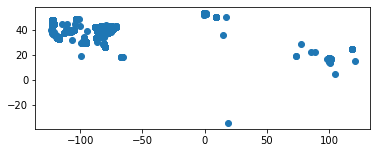

In [22]:
gdf = gpd.GeoDataFrame(
    df, geometry = gpd.points_from_xy(df.longitude, df.latitude)
)
gdf.set_crs(epsg=4326, inplace=True)

gdf.plot()

# Preview Each row of Data

Select and view different rows using the Row Dropdown menu

In [23]:
rows = df.index.tolist()

def view_row(row = 0):
    """Displays a Landcover DataFrame Row
    
    Arguments:
        row: int, the row index
        
    Returns:
        None
    """
    
    display(df.loc[row].to_frame())
    
interactive(view_row, row = rows)

interactive(children=(Dropdown(description='row', options=(2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

# Download Data as CSV
Downloads the data as a CSV file.

"get_raw": Setting Get Raw to true will get the raw data without QA scripts applied. The QA scripts disregard data that doesn't meet the following criteria:

- Contains photos for all directions or atleast the north photo
- Contains classifications for all directions

In [24]:
get_raw = False

In [21]:
def qa_filter(entry):
    """Determines if the passed entry is valid
    
    Arguments:
        entry: str, an entry in a Landcover DataFrame
    
    Returns:
        bool, if the passed entry is valid
    """
    
    return entry != None and ("rejected" not in entry and "none" not in entry)

vectorized_qa_filter = np.vectorize(qa_filter)

if not os.path.exists("Data"):
        os.makedirs("Data")

date = datetime.now().strftime("%d-%m-%Y")
download_type = "-RAW" if get_raw else ""
path = f"Data/LC-{date}{download_type}.csv" 
if not get_raw:
    # only gets data that has all 6 images or north image
    six_photos = np.all(vectorized_qa_filter(df[url_entries].to_numpy()), axis = 1)
    north_photos = vectorized_qa_filter(df[url_entries[3]].to_numpy())
    good_photo_data = np.logical_or(six_photos, north_photos)
    
    # data that has all classifications
    good_classification = np.all(vectorized_qa_filter(df[classifications].to_numpy()), axis = 1)
    good_data = np.logical_and(good_photo_data, good_classification)
    df[good_data].to_csv(path)
else:
    df.to_csv(path)

In [22]:
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,primary_type,primary_percentage,secondary_type,secondary_percentage,x_decimal,y_decimal,photo_count,classification_count,completeness,geometry
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-11-08T22:11:05,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350,2020,6,27,179,None,NaN,None,NaN,3,4,6,0,47,POINT (-105.23552 40.01456)
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-11-08T22:11:05,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585,2020,6,27,179,None,NaN,None,NaN,4,2,6,0,47,POINT (-105.25898 40.01992)
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-11-08T22:11:05,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 25.3517639...",https://data.globe.gov/system/photos/2020/06/0...,M91,https://data.globe.gov/system/photos/2020/06/0...,,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,"(source: app, (compassData.horizon: 24.8977747...",GLOBE Observer App,True,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,https://data.globe.gov/system/photos/2020/06/0...,,"(source: app, (compassData.horizon: -89.589040...","10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,2020-06-02T12:51:00,,https://data.globe.gov/system/photos/2020/06/0...,False,https://data.globe.gov/system/photos/2020/06/0...,False,True,3985

In [23]:
df[good_data]

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year,primary_type,primary_percentage,secondary_type,secondary_percentage,x_decimal,y_decimal,photo_count,classification_count,completeness,geometry
8,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-11-08T22:11:05,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 25.3517639...",https://data.globe.gov/system/photos/2020/06/0...,M91,https://data.globe.gov/system/photos/2020/06/0...,,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,"(source: app, (compassData.horizon: 24.8977747...",GLOBE Observer App,True,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,https://data.globe.gov/system/photos/2020/06/0...,,"(source: app, (compassData.horizon: -89.589040...","10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,2020-06-02T12:51:00,,https://data.globe.gov/system/photos/2020/06/0...,False,https://data.globe.gov/system/photos/2020/06/0...,False,True,398545.0,"(source: app, (compassData.horizon: 22.2352618...",,False,"(source: app, (compassData.horizon: 88.2102040...","(source: app, (compassData.horizon: 18.4345259...",31736,"Urban, Residential Property",False,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",(none),41.5747,191.9,-83.6250,2020,6,2,154,"MUC 91 [Urban, Residential Property]",70.0,"MUC 11 (n) [Trees, Loosely Spaced, Evergreen -...",10.0,3,4,6,4,58,POINT (-83.62560 41.57392)
10,land_covers,2020-06-09,2020-06-09T18:15:03,2020-06-12T14:05:03,2020-11-08T22:11:05,17043304,United States of America Citizen Science,52369,16SEJ191373,None,None,39.184731,-86.778849,231.0,163656702,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 11.1863002...",https://data.globe.gov/system/photos/2020/06/0...,M43,https://data.globe.gov/system/photos/2020/06/0...,,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,"(source: app, (compassData.horizon: 0.28608848...",GLOBE Observer App,False,"30% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,https://data.globe.gov/system/photos/2020/06/0...,,"(source: app, (compassData.horizon: -89.559527...","10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,2020-06-09T17:46:00,,https://data.globe.gov/system/photos/2020/06/0...,False,https://data.globe.gov/system/photos/2020/06/0...,False,True,24905746.0,"(source: app, (compassData.horizon: 13.8205975...",,True,"(source: app, (compassData.horizon: 83.4607460...","(source: app, (compassData.horizon: 10.7446774...",31896,"Herbaceous/Grassland, Short Grass",False,"80% MUC 02 (b) [Trees, Closely Spaced, Deciduo...",(none),39.1856,235.6,-86.7781,2020,6,9,161,"MUC 43 [Herbaceous/Grassland, Short Grass]",57.5,"MUC 02 (b) [Trees, Closely Spaced, Deciduous -...",27.5,4,4,6,4,56,POINT (-86.77885 39.18473)
11,land_covers,2020-06-02,2020-06-02T18:10:08,2020-06-03T16:25:51,2020-11-08T22:11:05,17043304,United States of America Citizen Science,52378,16SEJ191374,None,None,39.185632,-86.778846,235.5,163630634,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 6.09828849...",https://data.globe.gov/system/photos/2020/06/0..

# TODO
https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
- Surface Conditions?